In [ ]:
# Установка необходимых библиотек
%pip install tensorflow scikit-learn numpy

In [ ]:
# Импорт необходимых библиотек
import tensorflow as tf  # Библиотека для работы с нейронными сетями
from tensorflow.keras.layers import Layer, LSTM, Embedding, Dense  # Импорт слоев для построения модели
import numpy as np  # Библиотека для работы с массивами и математическими операциями
import re  # Модуль для работы с регулярными выражениями
from sklearn.model_selection import train_test_split  # Функция для разделения данных на обучающую и тестовую выборки

In [ ]:
# Скачивание файла с данными (замените ссылку на свою
!wget https://storage.yandexcloud.net/academy.ai/LLM/dialogs.txt

In [ ]:
# Класс для реализации механизма внимания (Attention Mechanism)
class AttentionMechanism(Layer):
    def __init__(self, method, units):
        super(AttentionMechanism, self).__init__()
        self.method = method  # Метод внимания (например, 'bahdanau', 'luong_gen', 'luong_concat')
        self.units = units  # Количество единиц (нейронов) в слоях внимания

        # Инициализация слоев в зависимости от выбранного метода
        if self.method == 'bahdanau':
            # Слои для метода Bahdanau (аддитивное внимание)
            self.W1 = Dense(units)  # Полносвязный слой для обработки запроса
            self.W2 = Dense(units)  # Полносвязный слой для обработки значений
            self.V = Dense(1)  # Полносвязный слой для вычисления score (оценки)
        elif self.method == 'luong_gen':
            # Слой для метода Luong (обобщенное внимание)
            self.W = Dense(units)  # Полносвязный слой для обработки значений
        elif self.method == 'luong_concat':
            # Слои для метода Luong (конкатенационное внимание)
            self.W = Dense(units)  # Полносвязный слой для обработки конкатенации
            self.V = Dense(1)  # Полносвязный слой для вычисления score (оценки)

    # Метод для вычисления контекстного вектора и весов внимания
    def call(self, query, values):
        if self.method == 'bahdanau':
            # Метод Bahdanau: вычисление score с использованием tanh и аддитивной функции
            query_with_time_axis = tf.expand_dims(query, 1)  # Добавление оси времени к запросу
            score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))  # Вычисление score
        elif self.method == 'luong_gen':
            # Метод Luong (обобщенное внимание): вычисление score через матричное умножение
            score = tf.matmul(values, tf.expand_dims(query, 2))  # Вычисление score
        elif self.method == 'luong_concat':
            # Метод Luong (конкатенационное внимание): вычисление score через конкатенацию и tanh
            query_with_time_axis = tf.expand_dims(query, 1)  # Добавление оси времени к запросу
            score = self.V(tf.nn.tanh(self.W(tf.concat([query_with_time_axis, values], axis=-1))))  # Вычисление score

        # Вычисление весов внимания с помощью функции softmax
        attention_weights = tf.nn.softmax(score, axis=1)
        # Вычисление контекстного вектора как взвешенной суммы значений
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)  # Суммирование по оси времени

        return context_vector, attention_weights  # Возврат контекстного вектора и весов внимания

In [ ]:
# Класс для реализации текстового энкодера (Text Encoder)
class TextEncoder(Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(TextEncoder, self).__init__()
        self.batch_sz = batch_sz  # Размер батча (количество примеров, обрабатываемых за один раз)
        self.enc_units = enc_units  # Количество единиц (нейронов) в LSTM слое
        self.embedding = Embedding(vocab_size, embedding_dim)  # Слой для векторного представления слов (Embedding)
        self.lstm = LSTM(self.enc_units, return_sequences=True, return_state=True)  # LSTM слой для обработки последовательностей

    # Метод для обработки входных данных
    def call(self, x):
        x = self.embedding(x)  # Преобразование входных индексов слов в векторные представления
        output, state_h, state_c = self.lstm(x)  # Обработка последовательности с помощью LSTM
        return output, state_h, state_c  # Возврат выходных данных, скрытого состояния и состояния ячейки

In [ ]:
# Класс для реализации текстового декодера (Text Decoder)
class TextDecoder(Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, attention_method='bahdanau'):
        super(TextDecoder, self).__init__()
        self.batch_sz = batch_sz  # Размер батча (количество примеров, обрабатываемых за один раз)
        self.dec_units = dec_units  # Количество единиц (нейронов) в LSTM слое
        self.embedding = Embedding(vocab_size, embedding_dim)  # Слой для векторного представления слов (Embedding)
        self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True)  # LSTM слой для обработки последовательностей
        self.fc = Dense(vocab_size)  # Полносвязный слой для предсказания следующего слова
        self.attention = AttentionMechanism(method=attention_method, units=self.dec_units)  # Механизм внимания

    # Метод для обработки входных данных
    def call(self, x, hidden, enc_output):
        # Вычисление контекстного вектора и весов внимания
        context_vector, attention_weights = self.attention(hidden, enc_output)
        # Преобразование входных индексов слов в векторные представления
        x = self.embedding(x)
        # Конкатенация контекстного вектора и векторного представления слова
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # Обработка последовательности с помощью LSTM
        output, state_h, state_c = self.lstm(x)
        # Преобразование выходных данных LSTM в нужную форму
        output = tf.reshape(output, (-1, output.shape[2]))
        # Предсказание следующего слова с помощью полносвязного слоя
        x = self.fc(output)
        return x, state_h, state_c, attention_weights  # Возврат предсказания, скрытого состояния, состояния ячейки и весов внимания

In [ ]:
# Функция для очистки предложения
def clean_sentence(sentence):
    sentence = sentence.lower().strip()  # Приведение к нижнему регистру и удаление лишних пробелов
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)  # Добавление пробелов вокруг знаков препинания
    sentence = re.sub(r'[" "]+', " ", sentence)  # Удаление лишних пробелов
    sentence = re.sub(r"[^a-zA-Zа-яА-Я?.!,¿]+", " ", sentence)  # Удаление всех символов, кроме букв и знаков препинания
    sentence = sentence.strip()  # Удаление лишних пробелов в начале и конце предложения
    sentence = '<start> ' + sentence + ' <end>'  # Добавление специальных токенов начала и конца предложения
    return sentence

# Функция для загрузки диалогов из файла
def load_dialogs(path):
    input_texts = []  # Список для хранения входных предложений
    target_texts = []  # Список для хранения целевых предложений
    with open(path, encoding='utf-8') as file:  # Открытие файла с диалогами
        for line in file:
            parts = line.strip().split("\t")  # Разделение строки на части по табуляции
            if len(parts) == 2:  # Проверка, что строка содержит два предложения
                input_texts.append(clean_sentence(parts[0]))  # Очистка и добавление входного предложения
                target_texts.append(clean_sentence(parts[1]))  # Очистка и добавление целевого предложения
    return input_texts, target_texts  # Возврат списков входных и целевых предложений

# Функция для токенизации текстов
def tokenize_texts(texts, vocab_size):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, filters='', oov_token='<unk>')  # Инициализация токенизатора
    tokenizer.fit_on_texts(texts)  # Обучение токенизатора на текстах
    tensor = tokenizer.texts_to_sequences(texts)  # Преобразование текстов в последовательности индексов
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  # Дополнение последовательностей до одинаковой длины
    return tensor, tokenizer  # Возврат тензора и токенизатора

In [ ]:
# Путь к файлу с диалогами
path = 'dialogs.txt'

# Загрузка диалогов из файла
input_texts, target_texts = load_dialogs(path)

# Установка размера словаря
vocab_size = 5000

# Токенизация входных текстов
input_tensor, inp_lang_tokenizer = tokenize_texts(input_texts, vocab_size)
# Токенизация целевых текстов
target_tensor, targ_lang_tokenizer = tokenize_texts(target_texts, vocab_size)

# Разделение данных на обучающую и валидационную выборки
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
    input_tensor, target_tensor, test_size=0.2  # 20% данных используются для валидации
)

In [ ]:
# Установка параметров модели
embedding_dim = 256  # Размерность векторного представления слов (Embedding)
units = 512  # Количество нейронов в LSTM слое
batch_size = 64  # Размер батча

# Создание экземпляров энкодера и декодера
encoder = TextEncoder(vocab_size, embedding_dim, units, batch_size)
decoder = TextDecoder(vocab_size, embedding_dim, units, batch_size)

# Инициализация оптимизатора и функции потерь
optimizer = tf.keras.optimizers.Adam()  # Оптимизатор Adam
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')  # Функция потерь

# Функция для вычисления потерь с учетом маскирования
def calculate_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))  # Создание маски для игнорирования нулевых значений (padding)
    loss_ = loss_object(real, pred)  # Вычисление потерь
    mask = tf.cast(mask, dtype=loss_.dtype)  # Приведение маски к типу данных потерь
    loss_ *= mask  # Применение маски к потерям
    return tf.reduce_mean(loss_)  # Возврат среднего значения потерь

# Декорированная функция для выполнения одного шага обучения
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0  # Инициализация переменной для накопления потерь
    with tf.GradientTape() as tape:  # Контекст для записи операций и вычисления градиентов
        # Кодирование входных данных
        enc_output, enc_hidden_h, enc_hidden_c = encoder(inp)
        dec_hidden = enc_hidden_h  # Инициализация скрытого состояния декодера
        # Начальный вход для декодера (токен <start>)
        dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * batch_size, 1)

        # Цикл по временным шагам целевой последовательности
        for t in range(1, targ.shape[1]):
            # Декодирование и предсказание следующего слова
            predictions, dec_hidden_h, dec_hidden_c, _ = decoder(dec_input, dec_hidden, enc_output)
            # Накопление потерь
            loss += calculate_loss(targ[:, t], predictions)
            # Обновление входного слова для следующего шага
            dec_input = tf.expand_dims(targ[:, t], 1)

    # Вычисление средних потерь на батч
    batch_loss = loss / int(targ.shape[1])
    # Получение списка обучаемых переменных
    variables = encoder.trainable_variables + decoder.trainable_variables
    # Вычисление градиентов
    gradients = tape.gradient(loss, variables)
    # Обновление весов модели
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss  # Возврат потерь на батч

# Количество эпох обучения
EPOCHS = 100

# Цикл обучения
for epoch in range(EPOCHS):
    total_loss = 0  # Инициализация переменной для накопления потерь за эпоху
    enc_hidden = tf.zeros((batch_size, units))  # Инициализация скрытого состояния энкодера
    # Цикл по батчам
    for batch in range(len(input_tensor_train)//batch_size):
        # Получение текущего батча
        batch_input = input_tensor_train[batch*batch_size:(batch+1)*batch_size]
        batch_target = target_tensor_train[batch*batch_size:(batch+1)*batch_size]
        # Выполнение шага обучения и получение потерь
        batch_loss = train_step(batch_input, batch_target, enc_hidden)
        total_loss += batch_loss  # Накопление потерь
    # Вывод средних потерь за эпоху
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(input_tensor_train)}')

Перевод: i enjoy the kinds of instruments that i enjoy the kinds of instruments that i enjoy the kinds of instruments that i enjoy the 


<ipython-input-9-b10ca10af151>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence.split(' '), rotation=90)
<ipython-input-9-b10ca10af151>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence.split(' '))


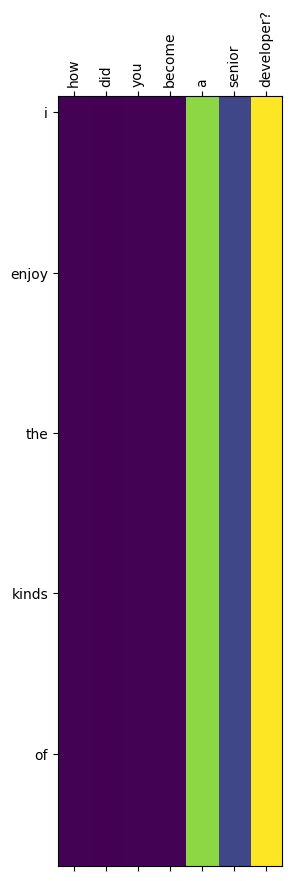

In [ ]:
# Функция для оценки (генерации перевода) предложения
def evaluate_sentence(sentence):
    attention_plot = np.zeros((max_len_targ, max_len_inp))  # Инициализация массива для хранения весов внимания
    sentence = clean_sentence(sentence)  # Очистка предложения

    # Преобразование предложения в последовательность индексов
    inputs = [inp_lang_tokenizer.word_index.get(i, inp_lang_tokenizer.word_index['<unk>']) for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_len_inp, padding='post')  # Дополнение до максимальной длины
    inputs = tf.convert_to_tensor(inputs)  # Преобразование в тензор

    result = ''  # Инициализация переменной для хранения результата
    enc_out, enc_hidden_h, enc_hidden_c = encoder(inputs)  # Кодирование входного предложения
    dec_hidden = enc_hidden_h  # Инициализация скрытого состояния декодера
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)  # Начальный вход для декодера (токен <start>)

    # Цикл по временным шагам для генерации перевода
    for t in range(max_len_targ):
        # Декодирование и предсказание следующего слова
        predictions, dec_hidden_h, dec_hidden_c, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        attention_weights = tf.reshape(attention_weights, (-1,))  # Преобразование весов внимания
        attention_plot[t] = attention_weights.numpy()  # Сохранение весов внимания

        # Получение индекса предсказанного слова
        predicted_id = tf.argmax(predictions[0]).numpy()
        # Добавление предсказанного слова к результату
        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        # Если предсказано слово <end>, завершаем генерацию
        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        # Обновление входного слова для следующего шага
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, attention_plot  # Возврат результата и весов внимания

# Определение максимальных длин входных и целевых последовательностей
max_len_inp = input_tensor.shape[1]
max_len_targ = target_tensor.shape[1]

# Функция для визуализации карты внимания
def plot_attention_map(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))  # Создание фигуры
    ax = fig.add_subplot(1, 1, 1)  # Добавление подграфика
    # Обрезка карты внимания до длины предсказанного и исходного предложения
    attention = attention[:len(predicted_sentence.split(' ')), :len(sentence.split(' '))]
    ax.matshow(attention, cmap='viridis')  # Отображение карты внимания

    # Настройка меток осей
    ax.set_xticklabels([''] + sentence.split(' '), rotation=90)
    ax.set_yticklabels([''] + predicted_sentence.split(' '))

    plt.show()  # Отображение графика

# Пример использования
sentence = "how did you become a senior developer?"
result, attention_plot = evaluate_sentence(sentence)  # Генерация перевода
print('Перевод:', result)  # Вывод перевода

# Визуализация карты внимания
import matplotlib.pyplot as plt
plot_attention_map(attention_plot, sentence, result)